### 점진적 학습
- 앞서 훈련한 모델을 버리지 않고 새로운 데이터에 대해서 조금씩 더 훈련하는 방법.
- 점진적 학습이 가능하다면 훈련에 사용한 데이터를 모두 유지할 필요도 없고 앞서 학습한 데이터를 까먹을 일도 없을 것이다.
- 대표적인 점진적 학습 알고리즘은 "확률적 경사 하강법(Stochastic Gradient Descent)"이다.

## Stochastic Gradient Descent (확률적 경사 하강법)
- 훈련 세트에서 딱 하나의 샘플을 '랜덤하게' 골라 가장 가파른 길을 찾는 *확률적 경사 하강법*
- 또 다른 샘플을 랜덤하게 선택해 가파른 길을 조금씩 조금씩 내려오면서 전체 훈련 샘플을 다 사용할 때까지 계속한다.
- 다시 처음부터 시작해 훈련 세트에 모든 샘플을 다시 채워 넣고, 다시 랜덤 샘플을 골라 만족할만한 위치에 도달할 때까지 계속 경사를 내려간다.
- **미니배치 경사 하강법 (Minibatch Gradient Descent)**: 여러 개의 샘플을 사용해 경사 하강법을 수행하는 방식
- **배치 경사 하강법(Batch Gradient Descent)**: 한 번 경사로를 따라 이동하기 위해 전체 샘플을 사용하는 방식
<br/><br/>
- **Epoch (에포크)**: 훈련 세트를 한 번 모두 사용하는 과정 (수십, 수백 번 이상 에포크를 수행함)


## Loss Function (손실 함수)
- Cost Function (비용 함수)
- 머신러닝 알고리즘이 얼마나 엉터리인지 측정하는 기준
- **Logistic Loss Function (로지스틱 손실 함수)**: 이진 분류에서 사용
    - Binary Cross-Entropy Loss Function (이진 크로스엔트로피 손실 함수)
    - 타겟이 1일 때, $ 손실 함수 = -log(예측 확률) $
    - 타겟이 0일 때, $ 손실 함수 = -log(1-예측 확률) $
- **Cross-Entropy Loss Function (크로스엔트로피 손실 함수)**: 다중 분류에서 사용
<br/><br/>
- mean_squared_error: 회귀 모델에서 사용하는 손실 함수
- 손실 함수를 직접 만드는 일은 거의 없다. 문제에 잘 맞는 손실 함수가 개발되어 있기 때문이다.



# 1. 데이터 준비

In [2]:
import pandas as pd
fish = pd.read_csv('https://bit.ly/fish_csv')

fish_data = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()
fish_target = fish['Species'].to_numpy()

from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(fish_data, fish_target, random_state = 42)
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(119, 5) (119,) (40, 5) (40,)


## 1-1. 데이터 표준화 처리

In [3]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(train_data)
train_scaled = scale.transform(train_data)
test_scaled = scale.transform(test_data)

# 2. 모델 학습 (SGDClassifier)
- SGDClassifier: scikit learn package에서 *확률적 경사 하강법*을 제공하는 대표적인 분류용 클래스
- SGDClassifier 객체를 만들 때 2개의 매개변수 `loss`(손실 함수), `max_iter`(에포크 반복 횟수) 지정
<br/><br/>
- 다중 분류의 경우, SGDClassifier에 loss = 'log'로 지정하면 클래스마다 이진 분류 모델을 만든다.
- 도미는 양성 클래스로 두고 나머지를 모두 음성 클래스로 두는 방식 **OvR (One versus Rest)** 이다.

In [4]:
from sklearn.linear_model import SGDClassifier
sc = SGDClassifier(loss = 'log', max_iter = 10, random_state = 42)
                            # 10 번의 에포크를 수행하겠다.
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))


0.773109243697479
0.775


/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [8]:
sc.partial_fit(train_scaled, train_target)
    # 모델을 추가로 훈련시킬 때 사용하는 method 
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.8487394957983193
0.85


# 3. 에포크와 과대/과소적합
- 에포크를 실행할수록 정확도가 향상한다. 무작정 반복하기 보다는 에포크를 얼마나 수행해야 하는지 기준이 필요하다.
- 에포크 횟수에 따라 과대/과소적합이 발생할 수 있다.
- 에포크가 진행될수록 훈련 세트 점수는 꾸준히 증가하지만 테스트 세트는 점수가 감소하는 시점이 발생한다 (과대적합).
- **조기종료**: 과대 적합이 발생하기 전에 훈련을 멈추는 것 

In [10]:
import numpy as np

sc = SGDClassifier(loss = 'log', random_state = 42)
train_score = []
test_score = []
classes = np.unique(train_target)

for _ in range(0, 300):
    sc.partial_fit(train_scaled, train_target, classes = classes)
            # partial_fit method 사용할 때는 훈련 세트에 있는 전체 클래스의 레이블을 전달해주어야 한다.
    train_score.append(sc.score(train_scaled, train_target))
    test_score.append(sc.score(test_scaled, test_target))

/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


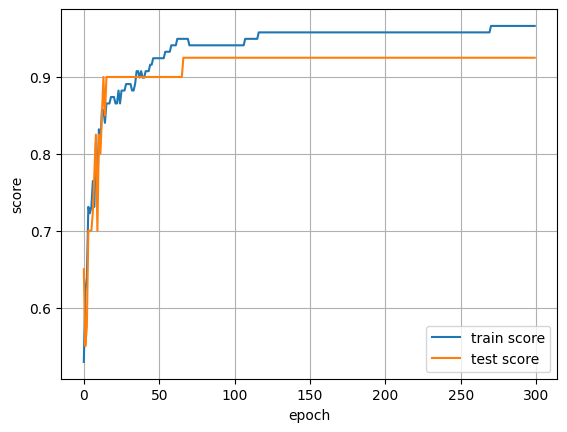

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_score, label = 'train score')
plt.plot(test_score, label = 'test score')
plt.legend(loc = 0)

plt.xlabel('epoch')
plt.ylabel('score')

plt.grid()
plt.show()


- 초기: 과소적합. 훈련 세트와 테스트 세트의 점수가 낮다.
- 100 번: 이후부터 과대적합. 점수 차이가 벌어지고 있다.
- 적절한 에포크 횟수는 100!

# 4. 모델 재학습 (SGDClassifier)
`SGDClassifier(loss = '손실 함수 지정', max_iter = 에포크 횟수, tol = 향상될 최솟값 지정)`
SGDClassifier는 일정 에포크 동안 성능이 향상되지 않으면 더 훈련하지 않고 자동으로 멈추는데, `tol = None`은 SGDClassifier가 자동으로 멈추지 않고 max_iter 값만큼 에포크를 수행하도록 한다.

In [14]:
sc = SGDClassifier(loss = 'log', max_iter = 100, tol = None, random_state = 42)
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.957983193277311
0.925


/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
